# Time-series synthetic data 
### A generation and evaluation example with **Clearbox Engine**

This notebook walks you through the time-series synthetic data generation and evaluation process with **Clearbox Engine**.

You can run this notebook on Google Colab or on your local machine.<br> 
In the second case, we highly recommend to create a dedicated virtual environment.

To run this notebook, make sure you change the runtime as <br>
*Runtime->Change Runtime Type* and set Hardware Accelerator to "GPU"

In [ ]:
# Install the library and its dependencies

%pip install clearbox-synthetic-kit

In [3]:
# Import necessary dependencies
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_platform_name", "cpu")

from clearbox_synthetic import (
        Dataset, 
        Preprocessor, 
        TimeSeriesEngine, 
    )

## 0. Data import and preparation

In [29]:
# Load the example datasets from GitHub

file_path = "https://raw.githubusercontent.com/Clearbox-AI/clearbox-synthetic-kit/main/examples/data/daily_delhi_climate"

train_dataset = Dataset.from_csv(
        os.path.join(file_path, "DailyDelhiClimateTrain.csv"),
    )

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


### Data pre-processing
Datasets are pre-processd with the **Preprocessor** class, which prepares data for the subsequent steps.

In [52]:
# Adding a time index column with year and month, as "yyyymm"
train_dataset.data['id'] =train_dataset.data['date'].apply(lambda x: ''.join(x.split('-')[0:2]))
prepro = Preprocessor(train_dataset, time_index='id', meta_columns=['date'])
X_train, meta = prepro.transform(train_dataset.data)

ts_id = train_dataset.data['id'].unique().shape[0]
print(f"Time series id found in the dataset: {ts_id}")
print(f"Number of time series channels found in the dataset: {prepro.n_time_features}")
print(f"Max time series length: {prepro.max_sequence_length}")

Time series id found in the dataset: 49
Number of time series channels found in the dataset: 4
Max time series length: 32


In [59]:
train_dataset.data

,date,meantemp,humidity,wind_speed,meanpressure,id
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,201301
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,201301
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,201301
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,201301
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,201301
...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,201612
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,201612
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,201612
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,201612


## 1. Synhetic Data Generation

In [13]:
# Initializing the time series generator

engine = TimeSeriesEngine(
    layers_size=[40],
    feature_sizes=prepro.n_time_features, # number of features
    max_sequence_length=prepro.max_sequence_length, # max time series length
    num_heads=4
)

(1, 32, 4)
(1, 32, 4)


In [14]:
import jax.numpy as jnp

def count_parameters(params_dict):
    total_count = 0
    for key, value in params_dict.items():
        if isinstance(value, dict):  # If the value is another dictionary, recurse
            total_count += count_parameters(value)
        elif isinstance(value, jnp.ndarray):  # If the value is an array, count parameters
            total_count += value.size
    return total_count

# Count the total number of parameters

total_params = count_parameters(engine.params['encoder'])
print("Number of parameters (encoder):", total_params)
total_params = count_parameters(engine.params['decoder'])
print("Number of parameters (decoder):", total_params)

Number of parameters (encoder): 26996
Number of parameters (decoder): 25120


In [15]:
# Start the training of the tabular synthetic data generator

engine.fit(X_train, epochs=5000, learning_rate=0.00001)

Engine fitting in progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]

(49, 32, 4)
(49, 32, 4)
(1000, 32, 4)
(1000, 32, 4)


Engine fitting in progress: 100%|██████████| 5000/5000 [03:33<00:00, 23.38epoch/s, Train loss=8540.004] 


In [22]:
engine.architecture

{'layers_size': [40],
 'y_shape': [0],
 'feature_sizes': 4,
 'max_sequence_length': 32,
 'num_heads': 4}

In [39]:
a,b,c=engine.apply(X_train)
b.shape

(49, 32, 4)
(49, 32, 4)


(49, 40)

In [73]:
# Generate the synthetic time series by decoding the samples from a gaussian distribution

synth_data = engine.decode(np.random.randn(b.shape[0],b.shape[1]))  # b.shape[1] dimensione dato da generare
synth_data_ = prepro.reverse_transform(synth_data)

In [78]:
synth_data.shape

(49, 128)

In [89]:
synth_data

Array([[-1.2128793 , -1.3550112 , -0.90740204, ..., -0.13121477,
        -0.28164878,  0.4034609 ],
       [ 0.14072727,  0.6461644 , -0.5556178 , ...,  0.27895084,
         0.77935934, -0.38873264],
       [-0.48368034, -0.88026756, -0.44051751, ...,  0.7160761 ,
         1.0061365 , -0.17799018],
       ...,
       [-0.10916393, -0.23073241, -0.18571527, ..., -0.8905872 ,
         0.16874509, -0.21749794],
       [-0.7986577 ,  0.00877775, -0.3049434 , ...,  0.7565725 ,
        -0.6804916 , -1.0896078 ],
       [ 0.06569315, -1.2189504 , -0.9755435 , ..., -0.1540089 ,
        -0.04138146, -0.0523669 ]], dtype=float32)

In [ ]:
train_dataset.data[train_dataset.data["id"]=="201301"]["meanpressure"]

In [87]:
X_train.shape

(49, 128)

In [ ]:
plt.plot(synth_data["meanpressure_0"])
plt.plot(X_train.data[train_dataset.data["id"]=="201301"]["meanpressure"])

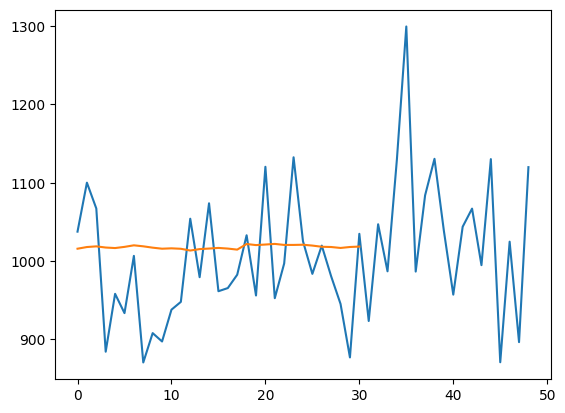

In [82]:
plt.plot(synth_data_["meanpressure_0"])
plt.plot(train_dataset.data[train_dataset.data["id"]=="201301"]["meanpressure"])